# Create precision-recall plots

In [43]:
import pandas as pd
import os
from glob import glob
from tqdm import tqdm
import numpy as np

from denovo_utils.utils.pandas import (
    get_decoy_status,
    collapse_casanovo_score,
    get_spectralis_score,
    get_psm_type,
    amino_acid_converter,
    drop_charge
)
from denovo_utils.analysis.evaluation import get_precision_coverage_df
import seaborn as sns


2024-09-23 15:11:25.009583: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-23 15:11:25.009622: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-23 15:11:25.010405: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Modification already exists in ModificationsDB. Skipping.


Two to three plots will be made.

1. PR plot of all tools together without post-processing of any kind. 

2. PR plot per engine. This will show 5 lines, where each tool is processed as follows:
    - De novo as such
    - De novo predictions with spectralis rescoring (Shows whether search engine or spectralis is better at scoring identifications)
    - spectralis refinement, rescored by seach engine (Shows whether refinement improves peptide sequences)
    - spectralis refinement with spectralis rescoring (Shows whether refinement improves peptide seauences or their scoring)
    - Instanovo+ refinement as such (Whether instanovo+ performs better for peptide sequence refinement or their scoring)
    - Instanovo+ refinement, rescored by seach engine (Whether this is better refiner)
    - Insatnovo+ refinement, rescored with spectralis

Optionally, if easily done, each tool will once again

3. For each engine, the stability of score vs accuracy is evaluated

### Load in data

In [2]:
df = pd.read_csv("/home/samva/Doctorate/data_directory/PXD028735/denovo_results/merged/LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_01.csv")

/tmp/ipykernel_9599/860113767.py:1: DtypeWarning: Columns (7,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/home/samva/Doctorate/data_directory/PXD028735/denovo_results/merged/LFQ_Orbitrap_DDA_Condition_A_Sample_Alpha_01.csv")


In [13]:
df.shape

(607933, 13)

### Label predictions with ground-truth

In [102]:
def evaluate_prediction(row, ground_truth):
    ground_truth_peptidoform = ground_truth[row["spectrum_id"]]["sequence"]
    if isinstance(ground_truth_peptidoform, type(None)):
        return None
    return ground_truth_peptidoform == row["sequence"]

def ground_truth_processing(df):
    df_db = df[df["source"]=="sage"]
    df_db = df_db.loc[df_db.groupby('spectrum_id')['score'].idxmax()]
    df_db["psm_type"] = df_db.apply(get_psm_type, axis=1)
    spectra_selection = df_db.loc[df_db["psm_type"]=="target_accepted", "spectrum_id"].tolist()

    df = df[df["source"]!="sage"]
    df = pd.concat([df, df_db]).reset_index(drop=True)

    df_processed = df[df["spectrum_id"].isin(spectra_selection)].copy()
    ground_truth = df_db.loc[df_db["psm_type"]=="target_accepted", ["sequence", "spectrum_id"]].set_index("spectrum_id").to_dict("index")
    df_processed["correct_prediction"] = df_processed.apply(lambda x: evaluate_prediction(x, ground_truth), axis=1)
    df_processed["proforma"] = df_processed["proforma"].apply(lambda x: x.replace("UNLMOD", "UNIMOD"))
    return df_processed

In [103]:
df_db = ground_truth_processing(df)

In [104]:
df_db.source.value_counts()

source
PepNet           59373
sage             59373
Casanovo4.2.0    59296
NovoB            59027
InstaNovo        50426
ContraNovo       29616
Name: count, dtype: int64

In [105]:
df_db.groupby("source").correct_prediction.value_counts(normalize=True)

source         correct_prediction
Casanovo4.2.0  False                 0.549717
               True                  0.450283
ContraNovo     True                  0.533968
               False                 0.466032
InstaNovo      False                 0.580554
               True                  0.419446
NovoB          False                 0.533552
               True                  0.466448
PepNet         False                 0.744716
               True                  0.255284
sage           True                  1.000000
Name: proportion, dtype: float64

In [106]:
metrics = {}

for engine in df.source.unique():
    if engine=="sage":
        continue
    print(engine)
    metrics_score = get_precision_coverage_df(
        df_db,
        source=engine,
        score_col="score",
        correctness_col="correct_prediction",
        ground_truth_source="sage",
    )
    metrics_score["engine"] = engine
    metrics[engine] = metrics_score

Casanovo4.2.0


/home/samva/miniconda3/envs/denovo_analysis_env/lib/python3.11/site-packages/denovo_utils/analysis/evaluation.py:90: RuntimeWarning: invalid value encountered in scalar divide
  lambda x: x["TP"] / (x["TP"] + x["FP"]), axis=1


InstaNovo


/home/samva/miniconda3/envs/denovo_analysis_env/lib/python3.11/site-packages/denovo_utils/analysis/evaluation.py:90: RuntimeWarning: invalid value encountered in scalar divide
  lambda x: x["TP"] / (x["TP"] + x["FP"]), axis=1


ContraNovo


/home/samva/miniconda3/envs/denovo_analysis_env/lib/python3.11/site-packages/denovo_utils/analysis/evaluation.py:90: RuntimeWarning: invalid value encountered in scalar divide
  lambda x: x["TP"] / (x["TP"] + x["FP"]), axis=1


PepNet


/home/samva/miniconda3/envs/denovo_analysis_env/lib/python3.11/site-packages/denovo_utils/analysis/evaluation.py:90: RuntimeWarning: invalid value encountered in scalar divide
  lambda x: x["TP"] / (x["TP"] + x["FP"]), axis=1


NovoB


/home/samva/miniconda3/envs/denovo_analysis_env/lib/python3.11/site-packages/denovo_utils/analysis/evaluation.py:90: RuntimeWarning: invalid value encountered in scalar divide
  lambda x: x["TP"] / (x["TP"] + x["FP"]), axis=1


<Axes: xlabel='coverage', ylabel='precision'>

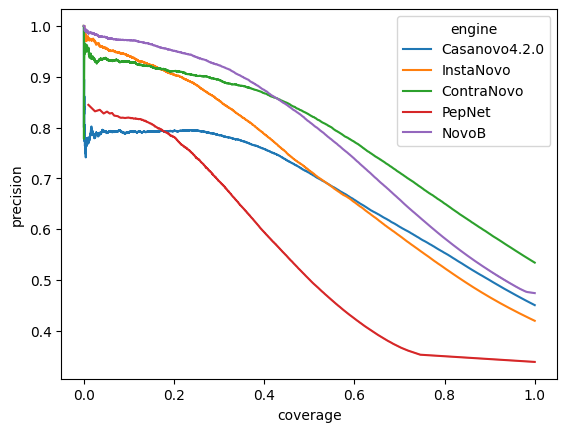

In [107]:
sns.lineplot(
    pd.concat(metrics.values()).reset_index(drop=True),
    x="coverage",
    y="precision",
    hue="engine"
)